- Caso de estudio del oro

In [16]:
# Librerías generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Librerías financieras y de datos
import yfinance as yf

# Preprocesamiento
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Red neuronal
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Guardado del modelo
import joblib
import os

# Reproducibilidad
import tensorflow as tf
import random

- Descarga de precios históricos

In [17]:
# Rango temporal
start_date = "2010-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Descarga de datos desde Yahoo Finance
df_oro = yf.download("GC=F", start=start_date, end=end_date)          # Futuros del oro
df_dxy = yf.download("DX-Y.NYB", start=start_date, end=end_date)      # Índice Dólar (DXY)
df_bonos = yf.download("^TNX", start=start_date, end=end_date)        # Bonos 10 años (proxy tasas)
df_inflacion = yf.download("TIP", start=start_date, end=end_date)     # ETF bonos indexados a inflación


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


- Visualizar los datos historicos

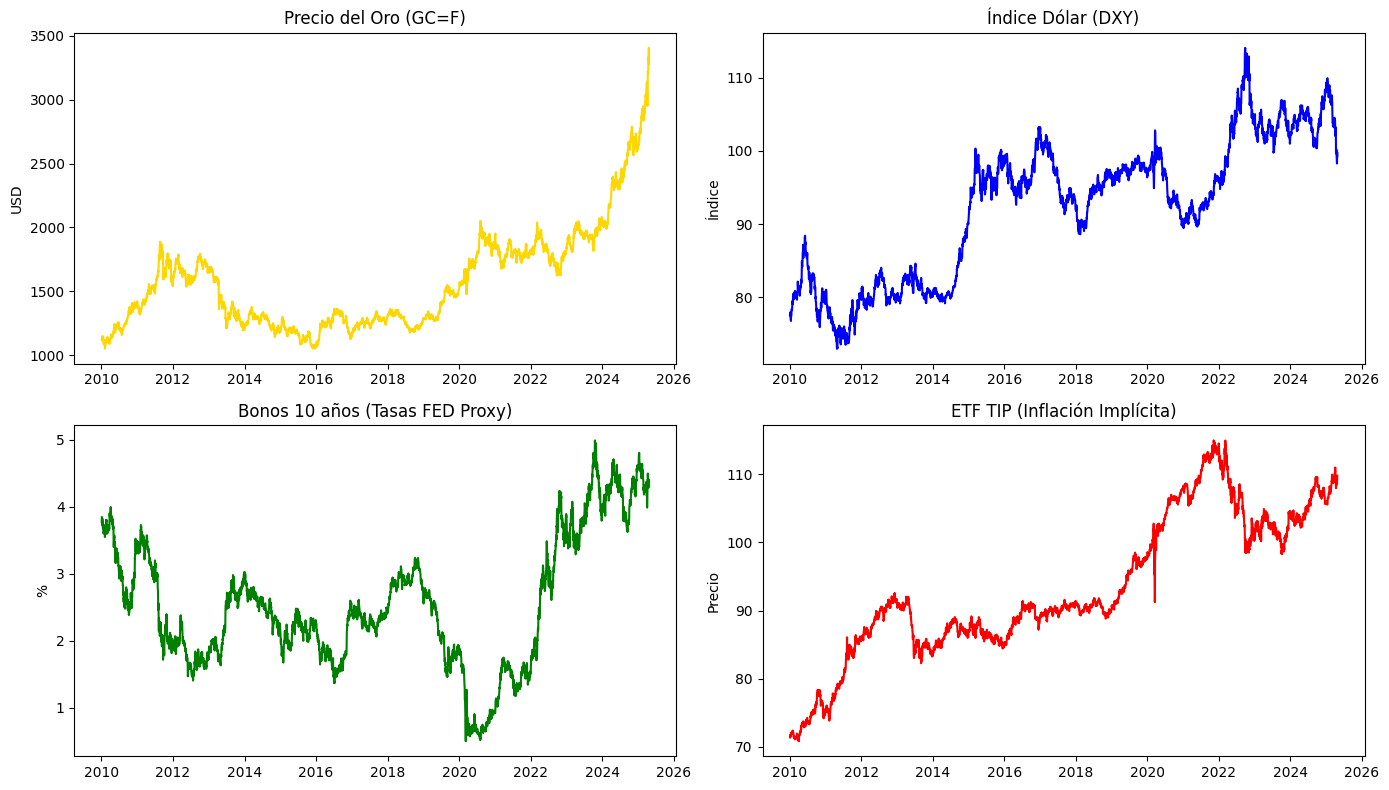

In [18]:
# Redibujo corregido
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(df_oro['Close'], label='GC=F', color='gold')
plt.title('Precio del Oro (GC=F)')
plt.ylabel('USD')

plt.subplot(2, 2, 2)
plt.plot(df_dxy['Close'], label='DXY', color='blue')
plt.title('Índice Dólar (DXY)')
plt.ylabel('Índice')

plt.subplot(2, 2, 3)
plt.plot(df_bonos['Close'], label='TNX', color='green')
plt.title('Bonos 10 años (Tasas FED Proxy)')
plt.ylabel('%')

plt.subplot(2, 2, 4)
plt.plot(df_inflacion['Close'], label='TIP', color='red')
plt.title('ETF TIP (Inflación Implícita)')
plt.ylabel('Precio')

# Removemos leyendas internas para evitar superposición
# Si deseas agregar leyendas, se recomienda usar: plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


### 3. Procesamiento de datos y feature engineering

- Combinación de las series temporales

In [19]:
# Usamos solo la columna de cierre
oro = df_oro['Close']
dxy = df_dxy['Close']
bonos = df_bonos['Close']
tip = df_inflacion['Close']

# Unificamos en un DataFrame común
df = pd.concat([oro, dxy, bonos, tip], axis=1)
df.columns = ['Oro', 'DXY', 'Bonos_10y', 'TIP']
df = df.dropna()

- 3.2 Cálculo de características personalizadas

In [20]:
# Ratio Oro/Dólar: se calcula con un lag para evitar data leakage
df['Ratio_Oro_Dolar'] = df['Oro'].shift(1) / df['DXY'].shift(1)

# Inflación implícita: variación porcentual mensual de TIP (ETF)
df['Inflacion_Imp'] = df['TIP'].pct_change(periods=21)  # aprox. 21 días hábiles = 1 mes

# Tasa real estimada: tasas nominales - inflación implícita
df['Tasa_Real'] = df['Bonos_10y'] - (df['Inflacion_Imp'] * 100)

# SMA 200 días (media móvil simple)
df['SMA_200'] = df['Oro'].rolling(window=200).mean()

# Bandas de Bollinger: medida de volatilidad histórica
std_20 = df['Oro'].rolling(window=20).std()
df['Bollinger_Upper'] = df['Oro'].rolling(window=20).mean() + 2 * std_20
df['Bollinger_Lower'] = df['Oro'].rolling(window=20).mean() - 2 * std_20

# Limpiar nulos tras cálculos
df = df.dropna()


- 3.3 Visualización de características

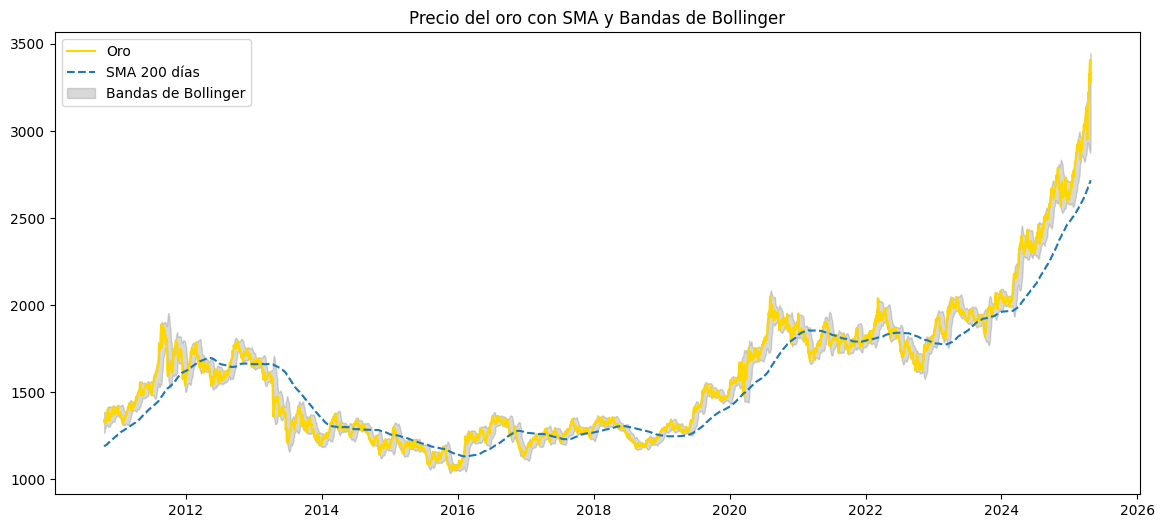

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(df['Oro'], label='Oro', color='gold')
plt.plot(df['SMA_200'], label='SMA 200 días', linestyle='--')
plt.fill_between(df.index, df['Bollinger_Upper'], df['Bollinger_Lower'], color='gray', alpha=0.3, label='Bandas de Bollinger')
plt.title("Precio del oro con SMA y Bandas de Bollinger")
plt.legend()
plt.show()


### 4. Normalización y generación de secuencias

- 4.1 Selección de features relevantes

In [22]:
# Lista de features a usar en el modelo
features = ['Oro', 'DXY', 'Bonos_10y', 'TIP', 'Ratio_Oro_Dolar', 'Inflacion_Imp', 'Tasa_Real']
df_model = df[features].copy()


- 4.2 Escalado robusto

In [23]:
from sklearn.preprocessing import RobustScaler

# Escalador robusto para cada feature
scaler = RobustScaler()
data_scaled = scaler.fit_transform(df_model)

- 4.3 Creación de secuencias para LSTM

In [24]:
look_back = 90
horizon = 5

# El target debe ser el precio del oro para predecir (columna 0)
target_oro = data_scaled[:, 0]

# Para evitar que el target se "coma" los últimos días del horizonte
data_input = data_scaled[:-horizon]
target_input = target_oro[:-horizon]

# Creamos el generador
generator = TimeseriesGenerator(
    data_input,
    targets=target_input,
    length=look_back,
    batch_size=32,
    sampling_rate=1,
    stride=1,
    shuffle=True
)

# Vista de ejemplo
X_sample, y_sample = generator[0]
print(f"X shape: {X_sample.shape}")  # (batch, 90, 7)
print(f"y shape: {y_sample.shape}")  # (batch,)


X shape: (32, 90, 7)
y shape: (32,)


### 5. División temporal del dataset

- 5.1 Reconstruimos un DataFrame escalado con fechas

In [25]:
# Creamos el DataFrame escalado de vuelta con fechas
df_scaled = pd.DataFrame(data_scaled, index=df_model.index, columns=df_model.columns)

- 5.2 Divisiones por fecha

In [26]:
# Entrenamiento: 2010 a 2018
df_train = df_scaled.loc["2010":"2018"]
# Validación: 2019 a 2020
df_val = df_scaled.loc["2019":"2020"]
# Test: 2021 en adelante
df_test = df_scaled.loc["2021":]


- 5.3 Crear generadores por subconjuntos

In [27]:
# Target = precio del oro (columna 0 en todos los subconjuntos)
train_generator = TimeseriesGenerator(
    df_train.values, df_train['Oro'].values,
    length=look_back, batch_size=32
)

val_generator = TimeseriesGenerator(
    df_val.values, df_val['Oro'].values,
    length=look_back, batch_size=32
)

test_generator = TimeseriesGenerator(
    df_test.values, df_test['Oro'].values,
    length=look_back, batch_size=32
)


### 6. Construcción del modelo LSTM

- 6.1 Arquitectura del modelo

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Entradas: 90 días, 7 características
model = Sequential([
    LSTM(192, input_shape=(look_back, df_train.shape[1]), return_sequences=True),
    Dropout(0.35),
    LSTM(96),
    Dense(1)  # Salida: 1 precio futuro del oro
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()


c:\Users\Eduardo\Desktop\EntonoTensorflow\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 90, 192)        │       153,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 96)             │       110,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,673 (1.01 MB)

 Trainable params: 264,673 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

### 7. Entrenamiento y evaluación

- 7.1 Callback de EarlyStopping

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)


- 7.2 Entrenar el modelo

In [30]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=80,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/80


c:\Users\Eduardo\Desktop\EntonoTensorflow\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0720 - mae: 0.2013 - val_loss: 0.0101 - val_mae: 0.0774
Epoch 2/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0057 - mae: 0.0571 - val_loss: 0.0096 - val_mae: 0.0674
Epoch 3/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0092 - mae: 0.0777 - val_loss: 0.0067 - val_mae: 0.0599
Epoch 4/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0050 - mae: 0.0535 - val_loss: 0.0116 - val_mae: 0.0904
Epoch 5/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0046 - mae: 0.0524 - val_loss: 0.0078 - val_mae: 0.0668
Epoch 6/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0046 - mae: 0.0504 - val_loss: 0.0110 - val_mae: 0.0789
Epoch 7/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0045 - mae: 0.0492 - val_loss: 0.0092 - val_mae: 0.0800
Epoch 8/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0032 - mae: 0.0447 - val_loss: 0.0093 - val_mae: 0.0784
Epoch 9/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0040 - mae:

- 7.3 Gráfica de la pérdida

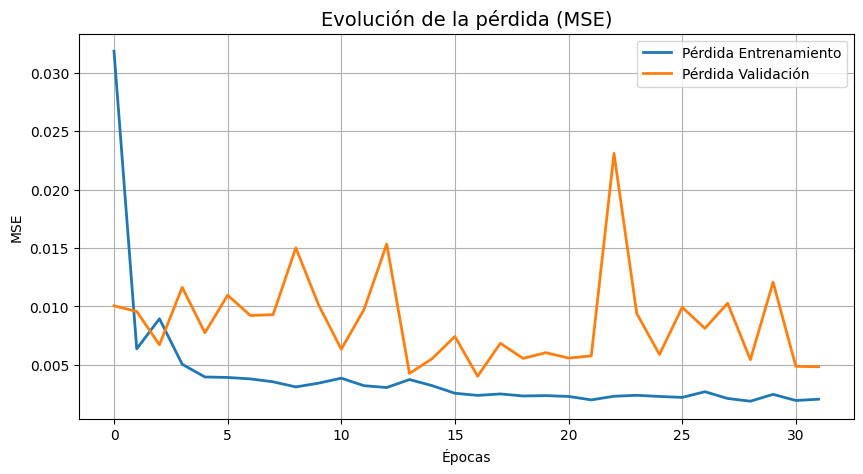

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida Entrenamiento', linewidth=2)
plt.plot(history.history['val_loss'], label='Pérdida Validación', linewidth=2)
plt.title("Evolución de la pérdida (MSE)", fontsize=14)
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


- 7.4 Evaluación en test set

In [32]:
loss, mae = model.evaluate(test_generator)

print(f"Evaluación en test:\n  - MSE: {loss:.4f}\n  - MAE: {mae:.4f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0359 - mae: 0.1282
Evaluación en test:
  - MSE: 0.1679
  - MAE: 0.2931


### 8. Visualización y análisis de resultados

- 8.1 Obtener predicciones en el conjunto de test

In [33]:
# Obtener las predicciones y los valores reales
y_pred = model.predict(test_generator)
y_real = test_generator.targets[look_back:]  # se pierden 'look_back' primeros por secuencias

# Invertimos la escala (solo la columna 'Oro')
oro_scaler = RobustScaler()
oro_scaler.fit(df_train[['Oro']])  # solo entrenamos con training
y_pred_inv = oro_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_real_inv = oro_scaler.inverse_transform(y_real.reshape(-1, 1)).flatten()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


- 8.2 Comparar visualmente predicción vs realidad

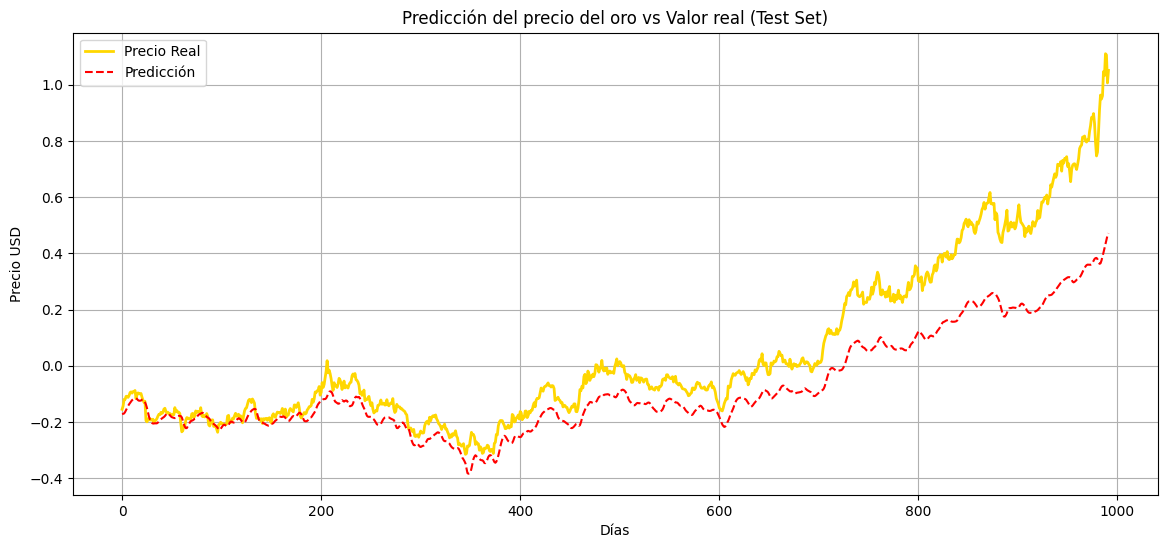

In [34]:
plt.figure(figsize=(14, 6))
plt.plot(y_real_inv, label='Precio Real', color='gold', linewidth=2)
plt.plot(y_pred_inv, label='Predicción', color='red', linestyle='--')
plt.title("Predicción del precio del oro vs Valor real (Test Set)")
plt.xlabel("Días")
plt.ylabel("Precio USD")
plt.legend()
plt.grid(True)
plt.show()


- 8.3 Métricas adicionales

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_real_inv, y_pred_inv))
mae = mean_absolute_error(y_real_inv, y_pred_inv)
mape = np.mean(np.abs((y_real_inv - y_pred_inv) / y_real_inv)) * 100

print(f"Evaluación Final en Test:")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"  MAPE: {mape:.2f}%")


Evaluación Final en Test:
  RMSE: 0.17
  MAE: 0.12
  MAPE: 358.41%


### 9. Guardado del modelo y normalizadores

- 9.1 Guardar el modelo entrenado

In [36]:
# Creamos una carpeta si no existe
os.makedirs("modelo_oro", exist_ok=True)

# Guardamos el modelo en formato HDF5
model.save("modelo_oro/modelo_lstm_oro.h5")
print("✅ Modelo guardado como modelo_lstm_oro.h5")

✅ Modelo guardado como modelo_lstm_oro.h5


- 9.2 Guardar el RobustScaler

In [37]:
# Guardamos el escalador de la variable Oro
joblib.dump(oro_scaler, "modelo_oro/scaler_oro.joblib")

# Guardamos el escalador de todo el conjunto si se desea
joblib.dump(scaler, "modelo_oro/scaler_completo.joblib")

print("✅ Escaladores guardados correctamente")


✅ Escaladores guardados correctamente


- 9.3 Metadata opcional

In [38]:
with open("modelo_oro/README.txt", "w") as f:
    f.write("Modelo LSTM para predicción del precio del oro\n")
    f.write("Entrenamiento: 2010-2018\n")
    f.write("Validación: 2019-2020\n")
    f.write("Test: 2021-Actualidad\n")
    f.write("Features: Oro, DXY, TIP, Bonos_10y, Ratio_Oro_Dolar, Inflación_Imp, Tasa_Real\n")
    f.write("Look-back: 90 días\n")
    f.write("Horizonte de predicción: 1 día\n")
    f.write("Modelo guardado en formato .h5\n")
